In [19]:
# import the necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
ruta_base = "../data/processed/"
# load data
df_transformed = pd.read_csv(ruta_base + "data-population-victims-of-armed-conflict.csv")

# Analize df
df_transformed.head(5)

,code_sspm,date_processing,code_municipality,municipality,departament,sex,ethnic_group,date_of_birth,years_in_the_visitia,commune,...,web_report_date,classification,p_age,p_sex,p_ethnicity,p_fact,vulnerability_index,ethnic_group_encoded,sex_Femenino,sex_Masculino
0,1,2012-06-05,76001,Cali,Valle del Cauca,Masculino,Mestizo,1964-06-16,47,8,...,2023-12-04,Adulthood,1,1,1,3,6,3,0,1
1,2,2012-06-05,76001,Cali,Valle del Cauca,Femenino,Mestizo,1970-10-27,41,8,...,2023-12-04,Adulthood,1,2,1,3,7,3,1,0
2,3,2012-06-05,76001,Cali,Valle del Cauca,Masculino,Mestizo,1996-10-04,15,8,...,2023-12-04,Youth,1,1,1,3,6,3,0,1
3,4,2012-06-05,76001,Cali,Valle del Cauca,Femenino,Mestizo,2007-06-12,4,8,...,2023-12-04,Childhood,2,2,1,3,8,3,1,0
4,5,2012-06-25,76001,Cali,Valle del Cauca,Femenino,Afrodescendiente,1970-05-20,42,8,...,2023-12-04,Adulthood,1,2,2,3,8,1,1,0


# Load

## Creation of DW

In [21]:
# Create database for DW
conn_dw = sqlite3.connect(ruta_base + "Project_ETL.db")
cursor_dw = conn_dw.cursor()

cursor_dw.executescript("""

-- DESACTIVAR CLAVES FORÁNEAS
PRAGMA foreign_keys = OFF;


-- ELIMINAR TABLAS (orden correcto)
DROP TABLE IF EXISTS victims;
DROP TABLE IF EXISTS person;
DROP TABLE IF EXISTS victimizing_act;
DROP TABLE IF EXISTS location;
DROP TABLE IF EXISTS registration_date;

-- ACTIVAR CLAVES FORÁNEAS
PRAGMA foreign_keys = ON;


-- CREAR DIMENSIONES
CREATE TABLE person (
    id_person INTEGER PRIMARY KEY NOT NULL,
    sex TEXT CHECK (sex IN ('Masculino', 'Femenino')),
    ethnic_group TEXT,
    classification TEXT
);

CREATE TABLE victimizing_act (
    id_act INTEGER PRIMARY KEY NOT NULL,
    victimization_fact TEXT
);

CREATE TABLE location (
    id_location INTEGER PRIMARY KEY NOT NULL,
    commune TEXT
);

CREATE TABLE registration_date (
    id_date INTEGER PRIMARY KEY NOT NULL,
    date_processing DATE,
    year INTEGER
);

CREATE TABLE victims (
    id_person INTEGER,
    id_act INTEGER,
    id_location INTEGER,
    id_date INTEGER,
    vulnerability_index INTEGER,
    total_victim INTEGER,
    FOREIGN KEY (id_person) REFERENCES person(id_person),
    FOREIGN KEY (id_act) REFERENCES victimizing_act(id_act),
    FOREIGN KEY (id_location) REFERENCES location(id_location),
    FOREIGN KEY (id_date) REFERENCES registration_date(id_date)
);""")

## separate column for data entry

In [22]:
# person column data
people = df_transformed[["sex", "ethnic_group","classification"]].drop_duplicates()
people["id_person"] = people.index + 1
people.head(5)

,sex,ethnic_group,classification,id_person
0,Masculino,Mestizo,Adulthood,1
1,Femenino,Mestizo,Adulthood,2
2,Masculino,Mestizo,Youth,3
3,Femenino,Mestizo,Childhood,4
4,Femenino,Afrodescendiente,Adulthood,5


In [23]:
# victimizing_act column data
victimizing_act = df_transformed[["victimization_fact"]].drop_duplicates().reset_index(drop=True)
victimizing_act["id_act"] = victimizing_act.index + 1
victimizing_act.head(15)

,victimization_fact,id_act
0,Desplazamiento forzado,1
1,No Registra,2
2,Homicidio,3
3,Amenaza,4
4,Desaparicion forzada,5
5,Eventos masivos,6
6,Acto terrorista/Atentados/Combates/Enfrentamie...,7
7,Perdida de Bienes Muebles o Inmuebles,8
8,Secuestro,9
9,Abandono o Despojo Forzado de Tierras,10


In [24]:
# registration_date column data
registration_date = df_transformed[["date_processing"]].drop_duplicates().copy()
registration_date["date_processing"] = pd.to_datetime(registration_date["date_processing"])
registration_date["year"] = registration_date["date_processing"].dt.year
registration_date["id_date"] = registration_date.index + 1
registration_date.head(10)

,date_processing,year,id_date
0,2012-06-05,2012,1
4,2012-06-25,2012,5
5,2012-08-08,2012,6
8,2012-06-19,2012,9
10,2012-06-10,2012,11
13,2012-06-12,2012,14
17,2012-06-13,2012,18
20,2023-11-03,2023,21
23,2012-06-14,2012,24
27,2020-11-09,2020,28


In [25]:
# location column data
location =  df_transformed[["commune"]].drop_duplicates()
location["id_location"] = location.index + 1
location.head(23)

,commune,id_location
0,8,1
20,12,21
76,11,77
89,15,90
148,9,149
391,10,392
628,13,629
671,19,672
1201,3,1202
1275,21,1276


In [26]:
# Load data into the DW
people.to_sql("person", conn_dw, if_exists="append", index=False)
victimizing_act.to_sql("victimizing_act", conn_dw, if_exists="append", index=False)
location.to_sql("location", conn_dw, if_exists="append", index=False)
registration_date.to_sql("registration_date", conn_dw, if_exists="append", index=False)

2570

In [27]:
# Function to display a table
def display_table(name_table):
  df_table = pd.read_sql(f"SELECT * FROM {name_table}", conn_dw)
  print(f"Tabla: {name_table}")
  display(df_table)


# Visualizar cada tabla del modelo dimensional
display_table("person")
display_table("victimizing_act")
display_table("location")
display_table("registration_date")

Tabla: person


,id_person,sex,ethnic_group,classification
0,1,Masculino,Mestizo,Adulthood
1,2,Femenino,Mestizo,Adulthood
2,3,Masculino,Mestizo,Youth
3,4,Femenino,Mestizo,Childhood
4,5,Femenino,Afrodescendiente,Adulthood
...,...,...,...,...
71,38700,Femenino,Rom,Childhood
72,42586,Masculino,Rom,Older adults
73,50879,Femenino,Rom,Youth
74,55297,Masculino,Raizal,Youth


Tabla: victimizing_act


,id_act,victimization_fact
0,1,Desplazamiento forzado
1,2,No Registra
2,3,Homicidio
3,4,Amenaza
4,5,Desaparicion forzada
5,6,Eventos masivos
6,7,Acto terrorista/Atentados/Combates/Enfrentamie...
7,8,Perdida de Bienes Muebles o Inmuebles
8,9,Secuestro
9,10,Abandono o Despojo Forzado de Tierras


Tabla: location


,id_location,commune
0,1,8
1,21,12
2,77,11
3,90,15
4,149,9
5,392,10
6,629,13
7,672,19
8,1202,3
9,1276,21


Tabla: registration_date


,id_date,date_processing,year
0,1,2012-06-05 00:00:00,2012
1,5,2012-06-25 00:00:00,2012
2,6,2012-08-08 00:00:00,2012
3,9,2012-06-19 00:00:00,2012
4,11,2012-06-10 00:00:00,2012
...,...,...,...
2565,70336,2023-09-09 00:00:00,2023
2566,70337,2023-08-20 00:00:00,2023
2567,70413,2023-09-22 00:00:00,2023
2568,70627,2023-11-22 00:00:00,2023


In [28]:
# Copiar dataframe original
fact = df_transformed.copy()

#  The two columns must have the same type in both dataframes
fact["date_processing"] = pd.to_datetime(fact["date_processing"])
registration_date["date_processing"] = pd.to_datetime(registration_date["date_processing"])


# Merge with person
fact = fact.merge(
    people[["id_person","sex","ethnic_group","classification"]],
    on=["sex","ethnic_group","classification"],
    how="left"
)


# Merge with victimizing_act
fact = fact.merge(
    victimizing_act[["id_act","victimization_fact"]],
    on="victimization_fact",
    how="left"
)


# Merge with location
fact = fact.merge(
    location[["id_location","commune"]],
    on="commune",
    how="left"
)


# Merge with date
fact = fact.merge(
    registration_date[["id_date","date_processing"]],
    on="date_processing",
    how="left"
)

# remove descriptive columns
fact = fact.drop(columns=[
    "sex",
    "ethnic_group",
    "victimization_fact",
    "commune",
    "date_processing"
])

In [29]:
# Create fact table
fact_table = fact[["id_person","id_act","id_location","id_date","vulnerability_index"]].copy()

fact_table["total_victim"] = len(fact_table)

In [30]:
# Load data to fact table
fact_table.to_sql("victims", conn_dw, if_exists="append", index=False)

70650

In [31]:
display_table("victims")

Tabla: victims


,id_person,id_act,id_location,id_date,vulnerability_index,total_victim
0,1,1,1,1,6,70650
1,2,1,1,1,7,70650
2,3,1,1,1,6,70650
3,4,1,1,1,8,70650
4,5,1,1,5,8,70650
...,...,...,...,...,...,...
70645,4,1,1558,70629,8,70650
70646,309,1,1276,13610,8,70650
70647,310,1,1276,13610,7,70650
70648,311,1,1276,13610,8,70650


# Visualization

## Total victims by gender over the years in Cali

<Figure size 640x480 with 0 Axes>

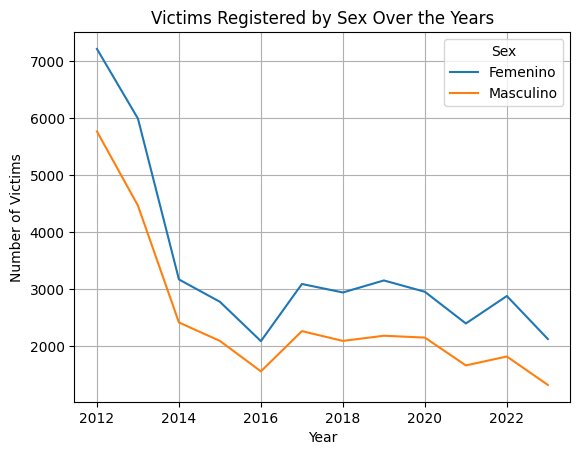

In [32]:
# Connection to the database
conn_dw = sqlite3.connect(ruta_base + "Project_ETL.db")

# obtain victims by gender and year
query = """
SELECT
    rd.year,
    p.sex,
    COUNT(*) as total_victims
FROM victims v
JOIN person p ON v.id_person = p.id_person
JOIN registration_date rd ON v.id_date = rd.id_date
GROUP BY rd.year, p.sex
ORDER BY rd.year;
"""

df_chart = pd.read_sql(query, conn_dw)

# Pivot for multi-line format
df_pivot = df_chart.pivot(
    index="year",
    columns="sex",
    values="total_victims"
)

# Create chart
plt.figure()
df_pivot.plot()

plt.title("Victims Registered by Sex Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Victims")
plt.legend(title="Sex")
plt.grid(True)

plt.show()

## Total number of victims by ethnic group processed

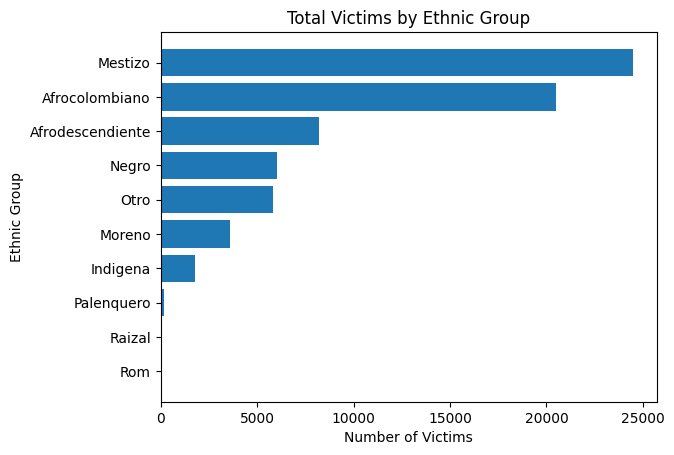

In [33]:
# # Connect to the DW
conn_dw = sqlite3.connect(ruta_base + "Project_ETL.db")

# query to obtain total number of victims by ethnic group
query = """
SELECT
    p.ethnic_group,
    COUNT(*) as total_victims
FROM victims v
JOIN person p ON v.id_person = p.id_person
GROUP BY p.ethnic_group
ORDER BY total_victims DESC;
"""

df_chart = pd.read_sql(query, conn_dw)

# Create horizontal bar chart
plt.figure()
plt.barh(df_chart["ethnic_group"], df_chart["total_victims"])

plt.title("Total Victims by Ethnic Group")
plt.xlabel("Number of Victims")
plt.ylabel("Ethnic Group")

plt.gca().invert_yaxis()  # So that the older one stays on top
plt.show()

## What is the most common victimization by municipality in Cali?

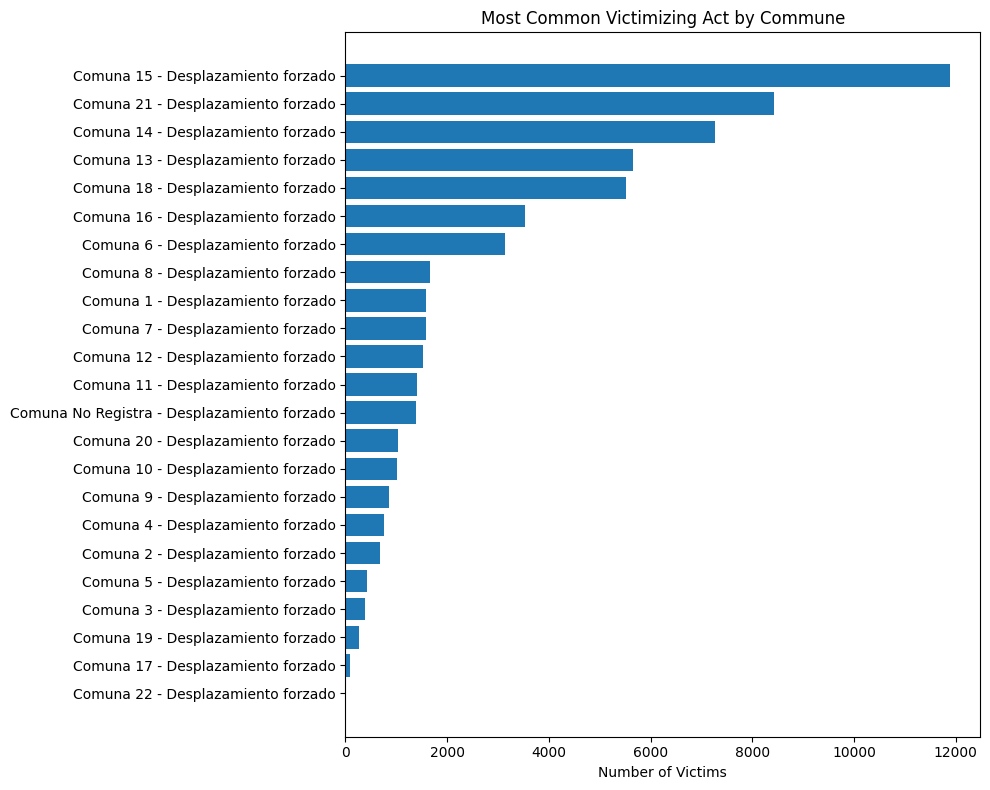

In [34]:
# Group by municipality and event
grouped = (
    df_transformed
    .groupby(['commune', 'victimization_fact'])
    .size()
    .reset_index(name='total_victims')
)

# Get the most common fact by municipality
idx = grouped.groupby('commune')['total_victims'].idxmax()
most_common = grouped.loc[idx].reset_index(drop=True)

# Sort by number of victims
most_common = most_common.sort_values(by='total_victims', ascending=True)

# Create label (Commune - Done)
most_common['label'] = (
    "Comuna " + most_common['commune'].astype(str) +
    " - " + most_common['victimization_fact']
)

#  Horizontal chart
plt.figure(figsize=(10, 8))
plt.barh(most_common['label'], most_common['total_victims'])

plt.xlabel("Number of Victims")
plt.title("Most Common Victimizing Act by Commune")

plt.tight_layout()
plt.show()

## Year in which the highest number of victims were processed.

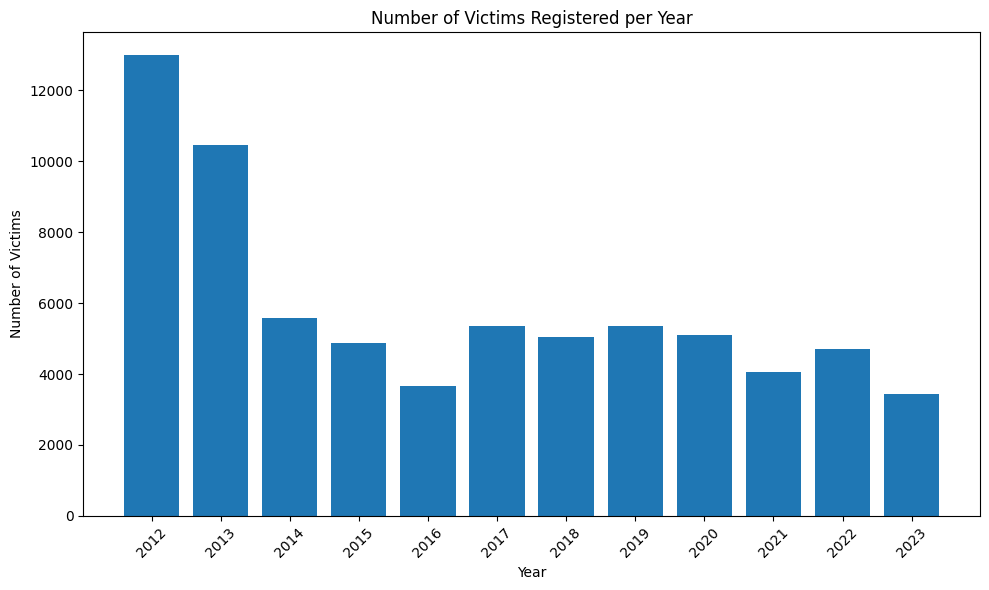

In [35]:
# Connect to the DW
conn = sqlite3.connect(ruta_base + "Project_ETL.db")

query = """
SELECT rd.year, COUNT(*) AS total_victims
FROM victims v
JOIN registration_date rd ON v.id_date = rd.id_date
GROUP BY rd.year
ORDER BY rd.year;
"""

victims_per_year = pd.read_sql(query, conn)
conn.close()

# Gráfico
plt.figure(figsize=(10,6))

plt.bar(victims_per_year['year'], victims_per_year['total_victims'])

plt.xlabel("Year")
plt.ylabel("Number of Victims")
plt.title("Number of Victims Registered per Year")

#  Mostrar TODOS los años en el eje X
plt.xticks(victims_per_year['year'], rotation=45)

plt.tight_layout()
plt.show()

## Most common victimizing act by gender

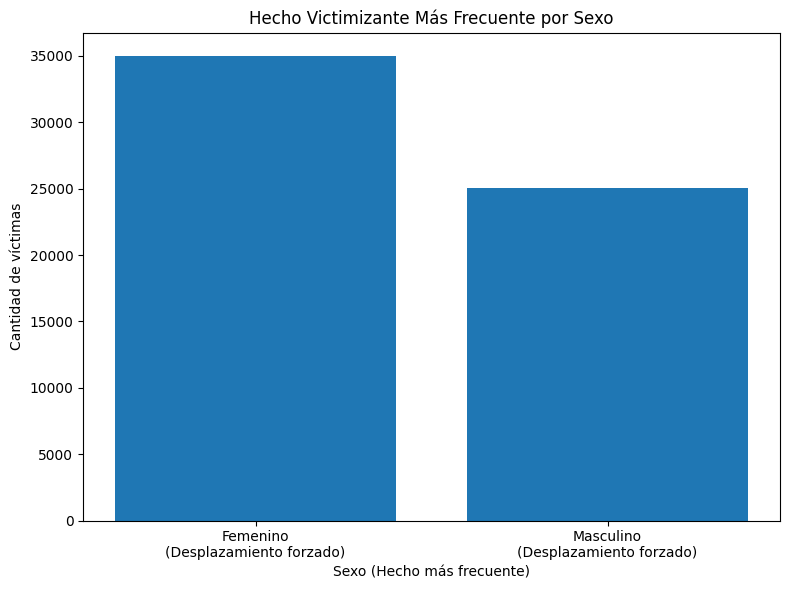

In [36]:
conn = sqlite3.connect(ruta_base + "Project_ETL.db")

# Read tables
victims = pd.read_sql_query("SELECT * FROM victims", conn)
person = pd.read_sql_query("SELECT id_person, sex FROM person", conn)
victimizing_act = pd.read_sql_query("SELECT id_act, victimization_fact FROM victimizing_act", conn)

conn.close()

# Merge 
df_merge = victims.merge(
    person,
    on='id_person',
    how='left'
).merge(
    victimizing_act,
    on='id_act',
    how='left'
)

# Counting
df_grouped = df_merge.groupby(
    ['sex', 'victimization_fact']
).size().reset_index(name='total')

# Most frequent victimization by gender
idx = df_grouped.groupby('sex')['total'].idxmax()
df_top = df_grouped.loc[idx].reset_index(drop=True)



# Graph
x = np.arange(len(df_top))

plt.figure(figsize=(8,6))
plt.bar(x, df_top['total'])

plt.xticks(
    x,
    [f"{row['sex']}\n({row['victimization_fact']})" for _, row in df_top.iterrows()]
)

plt.xlabel("Sexo (Hecho más frecuente)")
plt.ylabel("Cantidad de víctimas")
plt.title("Hecho Victimizante Más Frecuente por Sexo")

plt.tight_layout()
plt.show()